## Import All Libraries 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interact

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.inspection import permutation_importance

# Read Data 

In [3]:
click_df=pd.read_csv('property_data_set.csv',parse_dates = ['activation_date'],infer_datetime_format = True, dayfirst=True)

In [4]:
click_df.head()

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,...,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,...,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP
1,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,...,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP
2,ff808081470c645401470fb03f5800a6,BHK2,2017-03-10 13:43:00,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,...,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP
3,ff808081470c6454014715eaa5960281,BHK3,2017-03-09 22:16:00,2,3,4.0,SEMI_FURNISHED,0,12.888169,77.591282,...,0,Arakere,BOTH,1,1300,0,560076.0,17000,150000,AP
4,ff808081474aa867014771a0298f0aa6,BHK1,2017-03-15 18:29:00,1,1,2.0,SEMI_FURNISHED,0,12.990243,77.712962,...,0,Hoodi,BOTH,4,450,0,560048.0,6500,40000,IF


In [5]:
pics_df=pd.read_table('property_photos.tsv')

In [6]:
pics_df.head()

,property_id,photo_urls
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006..."
1,ff8080814702d3d10147068359d200cd,NaN
2,ff808081470c645401470fb03f5800a6,"[{\title\"":\""Bedroom\"",\""name\"":\""ff808081470c..."
3,ff808081470c6454014715eaa5960281,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_7..."
4,ff808081474aa867014771a0298f0aa6,"[{\title\"":\""Other\"",\""name\"":\""ff808081474aa8..."


In [7]:
sample_text=pics_df['photo_urls'][0]

In [8]:
print(sample_text)

[{\title\":\"Balcony\",\"name\":\"IMG_20131006_120837.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_65149_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_65149_thumbnail.jpg\",\"medium\":\"ff808081469fd6e20146a5af948000ea_65149_medium.jpg\",\"large\":\"ff808081469fd6e20146a5af948000ea_65149_large.jpg\"},\"displayPic\":false},{\"title\":\"Bathroom\",\"name\":\"IMG_20131006_120734.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_63511_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_63511_thumbnail.jpg\",\"medium\":\"ff808081469fd6e20146a5af948000ea_63511_medium.jpg\",\"large\":\"ff808081469fd6e20146a5af948000ea_63511_large.jpg\"},\"displayPic\":false},{\"title\":\"Bedroom\",\"name\":\"IMG_20131006_120643.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_16708_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_16708_thumbnail.jpg\",\"medium\":\"ff808081469fd6e20146a5af948000ea_16708_

In [9]:
process_text = sample_text.replace('\\' , '').replace('{title','{"title').replace(']"' , ']').replace('],"', ']","')

In [10]:
print(json.loads(process_text))

[{'title': 'Balcony', 'name': 'IMG_20131006_120837.jpg', 'imagesMap': {'original': 'ff808081469fd6e20146a5af948000ea_65149_original.jpg', 'thumbnail': 'ff808081469fd6e20146a5af948000ea_65149_thumbnail.jpg', 'medium': 'ff808081469fd6e20146a5af948000ea_65149_medium.jpg', 'large': 'ff808081469fd6e20146a5af948000ea_65149_large.jpg'}, 'displayPic': False}, {'title': 'Bathroom', 'name': 'IMG_20131006_120734.jpg', 'imagesMap': {'original': 'ff808081469fd6e20146a5af948000ea_63511_original.jpg', 'thumbnail': 'ff808081469fd6e20146a5af948000ea_63511_thumbnail.jpg', 'medium': 'ff808081469fd6e20146a5af948000ea_63511_medium.jpg', 'large': 'ff808081469fd6e20146a5af948000ea_63511_large.jpg'}, 'displayPic': False}, {'title': 'Bedroom', 'name': 'IMG_20131006_120643.jpg', 'imagesMap': {'original': 'ff808081469fd6e20146a5af948000ea_16708_original.jpg', 'thumbnail': 'ff808081469fd6e20146a5af948000ea_16708_thumbnail.jpg', 'medium': 'ff808081469fd6e20146a5af948000ea_16708_medium.jpg', 'large': 'ff808081469fd

### We correct for the errors in the JSON file and create a feature called photo count which measures the number of photos uploaded about the property.

In [11]:
def replacevalues(x):
    if x is np.nan or x=='Nan':
        return 0
    else:
        return len(json.loads( x.replace('\\' , '').replace('{title','{"title').replace(']"' , ']').replace('],"', ']","')))

In [12]:
pics_df['photo_count']=pics_df['photo_urls'].apply(replacevalues)

In [13]:
pics_df.head(5)

,property_id,photo_urls,photo_count
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006...",7
1,ff8080814702d3d10147068359d200cd,NaN,0
2,ff808081470c645401470fb03f5800a6,"[{\title\"":\""Bedroom\"",\""name\"":\""ff808081470c...",12
3,ff808081470c6454014715eaa5960281,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_7...",9
4,ff808081474aa867014771a0298f0aa6,"[{\title\"":\""Other\"",\""name\"":\""ff808081474aa8...",7


In [14]:
interact_df=pd.read_csv('property_interactions.csv',parse_dates = ['request_date'] , infer_datetime_format = True, dayfirst=True)

In [15]:
interact_df.head(5)

,property_id,request_date
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15


In [16]:
print(click_df.shape)
print(pics_df.shape)
print(interact_df.shape)

(28888, 21)
(28888, 3)
(170611, 2)


## We now merge the dataframes together once they have been cleaned

In [17]:
num_req = pd.merge(click_df, interact_df, on ='property_id')[['property_id', 'request_date', 'activation_date']]

In [18]:
num_req.head()

,property_id,request_date,activation_date
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34,2017-03-09 14:36:00
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17,2017-03-09 14:36:00
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22,2017-03-09 14:36:00
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46,2017-03-09 14:36:00
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15,2017-03-07 12:02:00


In [19]:
num_req['request_day'] = (num_req['request_date'] - num_req['activation_date']) / np.timedelta64(1, 'D')

In [20]:
num_req.head(5)

,property_id,request_date,activation_date,request_day
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34,2017-03-09 14:36:00,1.129560
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17,2017-03-09 14:36:00,0.052280
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22,2017-03-09 14:36:00,1.121088
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46,2017-03-09 14:36:00,2.133866
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15,2017-03-07 12:02:00,23.331424


## Interactions within 3 days

### We now create a new column which aggreagates the visits recieved over an 3 day period after the property is activated on the platform

In [21]:
num_req_within_3d = num_req[num_req['request_day'] < 3].groupby('property_id').agg({'request_day':'count'})

In [22]:
num_req_within_3d = num_req_within_3d.rename({'request_day':'request_day_within_3d'},axis=1)

In [23]:
num_req_within_3d.head(5)

,request_day_within_3d
property_id,
ff808081469fd6e20146a5af948000ea,4
ff8080814702d3d10147068359d200cd,3
ff808081470c645401470fb03f5800a6,15
ff808081470c6454014715eaa5960281,5
ff808081474aa867014771a0298f0aa6,25


In [24]:
num_req_within_3d['request_day_within_3d'].value_counts()[:10]

1     5940
2     2741
3     1579
4      887
5      583
6      373
7      246
8      186
9      148
11     105
Name: request_day_within_3d, dtype: int64

## We now convert number of requests within 3 days into 3 Categories and create a new feature

In [25]:
def divide(x):
    if x in [1,2]:
        return 'cat_1_to_2'
    elif x in [3,4,5]:
        return 'cat_3_to_5'
    else:
        return 'cat_above_5'

In [26]:
num_req_within_3d['categories_3day'] = num_req_within_3d['request_day_within_3d'].apply(divide)

In [27]:
num_req_within_3d.head(3)

,request_day_within_3d,categories_3day
property_id,,
ff808081469fd6e20146a5af948000ea,4,cat_3_to_5
ff8080814702d3d10147068359d200cd,3,cat_3_to_5
ff808081470c645401470fb03f5800a6,15,cat_above_5


In [28]:
num_req_within_3d['categories_3day'].value_counts()

cat_1_to_2     8681
cat_3_to_5     3049
cat_above_5    1480
Name: categories_3day, dtype: int64

## Interaction within 8 days 

### We now create a new column which aggreagates the visits recieved over an 8 day period after the property is activated on the platform

In [29]:
num_req_within_8d=num_req[num_req['request_day']<8].groupby('property_id').agg({'request_day':'count'})

In [30]:
num_req_within_8d = num_req_within_8d.rename({'request_day':'request_day_within_8d'},axis=1)

In [31]:
num_req_within_8d.head(8)

,request_day_within_8d
property_id,
ff808081469fd6e20146a5af948000ea,4
ff8080814702d3d10147068359d200cd,6
ff808081470c645401470fb03f5800a6,23
ff808081470c6454014715eaa5960281,7
ff808081474aa867014771a0298f0aa6,56
ff8080814780f30801478d14132f03f4,1
ff8080814780f308014797c79000082e,3
ff80808147a95f0a0147ab0d88fa0080,4


## We now convert number of requests within 8 days into 3 Categories  

In [32]:
num_req_within_8d['categories_8day'] = num_req_within_8d['request_day_within_8d'].apply(divide)

In [33]:
num_req_within_8d.head(3)

,request_day_within_8d,categories_8day
property_id,,
ff808081469fd6e20146a5af948000ea,4,cat_3_to_5
ff8080814702d3d10147068359d200cd,6,cat_above_5
ff808081470c645401470fb03f5800a6,23,cat_above_5


In [34]:
num_req_within_8d['categories_8day'].value_counts()

cat_1_to_2     9181
cat_3_to_5     4774
cat_above_5    3970
Name: categories_8day, dtype: int64

## DataFrame Merge

In [35]:
click_df.head(2)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,...,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,...,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP
1,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,...,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP


In [36]:
pics_df.head(2)

,property_id,photo_urls,photo_count
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006...",7
1,ff8080814702d3d10147068359d200cd,NaN,0


In [37]:
interact_df.head(2)

,property_id,request_date
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17


In [38]:
num_req.head(2)

,property_id,request_date,activation_date,request_day
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34,2017-03-09 14:36:00,1.12956
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17,2017-03-09 14:36:00,0.05228


In [39]:
num_req_within_3d.head(2)

,request_day_within_3d,categories_3day
property_id,,
ff808081469fd6e20146a5af948000ea,4,cat_3_to_5
ff8080814702d3d10147068359d200cd,3,cat_3_to_5


In [40]:
num_req_within_8d.head(2)

,request_day_within_8d,categories_8day
property_id,,
ff808081469fd6e20146a5af948000ea,4,cat_3_to_5
ff8080814702d3d10147068359d200cd,6,cat_above_5


In [41]:
print(click_df.shape)
print(pics_df.shape)
print(interact_df.shape)

(28888, 21)
(28888, 3)
(170611, 2)


In [42]:
print(num_req.shape)
print(num_req_within_3d.shape)
print(num_req_within_8d.shape)

(170611, 4)
(13210, 2)
(17925, 2)


In [43]:
joint_data = pd.merge(num_req_within_8d, num_req_within_3d, on ='property_id' , how='left')

In [44]:
joint_data.head(2)

,request_day_within_8d,categories_8day,request_day_within_3d,categories_3day
property_id,,,,
ff808081469fd6e20146a5af948000ea,4,cat_3_to_5,4.0,cat_3_to_5
ff8080814702d3d10147068359d200cd,6,cat_above_5,3.0,cat_3_to_5


In [45]:
joint_data.isna().sum()

request_day_within_8d       0
categories_8day             0
request_day_within_3d    4715
categories_3day          4715
dtype: int64

In [46]:
df_click_pics=pd.merge(click_df,pics_df,on='property_id',how='left')

In [47]:
df_click_pics.head(2)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,...,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,photo_urls,photo_count
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,...,BOTH,2,850,1,560076.0,12000,120000,AP,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006...",7
1,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,...,BOTH,1,1233,1,560016.0,20000,150000,AP,NaN,0


In [48]:
final_df=pd.merge(df_click_pics,joint_data,on='property_id',how='left')

In [49]:
final_df.head(2)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,...,pin_code,rent,deposit,building_type,photo_urls,photo_count,request_day_within_8d,categories_8day,request_day_within_3d,categories_3day
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,...,560076.0,12000,120000,AP,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006...",7,4.0,cat_3_to_5,4.0,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,...,560016.0,20000,150000,AP,NaN,0,6.0,cat_above_5,3.0,cat_3_to_5


In [50]:
final_df.isna().sum()

property_id                  0
type                         0
activation_date              0
bathroom                     0
floor                        0
total_floor                 43
furnishing                   0
gym                          0
latitude                     0
longitude                    0
lease_type                   0
lift                         0
locality                     0
parking                      0
property_age                 0
property_size                0
swimming_pool                0
pin_code                   325
rent                         0
deposit                      0
building_type               79
photo_urls               11022
photo_count                  0
request_day_within_8d    10963
categories_8day          10963
request_day_within_3d    15678
categories_3day          15678
dtype: int64

## Exploratory Data Analysis  

In [51]:
final_df= final_df.drop(['property_id', 'activation_date' ,'latitude', 'longitude', 'pin_code','photo_urls','locality'] , axis=1)

In [52]:
print('Num. of null values')
print(dict(final_df.isna().sum()))
print('\n')
print('data type')
print(dict(final_df.dtypes))

Num. of null values
{'type': 0, 'bathroom': 0, 'floor': 0, 'total_floor': 43, 'furnishing': 0, 'gym': 0, 'lease_type': 0, 'lift': 0, 'parking': 0, 'property_age': 0, 'property_size': 0, 'swimming_pool': 0, 'rent': 0, 'deposit': 0, 'building_type': 79, 'photo_count': 0, 'request_day_within_8d': 10963, 'categories_8day': 10963, 'request_day_within_3d': 15678, 'categories_3day': 15678}


data type
{'type': dtype('O'), 'bathroom': dtype('int64'), 'floor': dtype('int64'), 'total_floor': dtype('float64'), 'furnishing': dtype('O'), 'gym': dtype('int64'), 'lease_type': dtype('O'), 'lift': dtype('int64'), 'parking': dtype('O'), 'property_age': dtype('int64'), 'property_size': dtype('int64'), 'swimming_pool': dtype('int64'), 'rent': dtype('int64'), 'deposit': dtype('int64'), 'building_type': dtype('O'), 'photo_count': dtype('int64'), 'request_day_within_8d': dtype('float64'), 'categories_8day': dtype('O'), 'request_day_within_3d': dtype('float64'), 'categories_3day': dtype('O')}


In [53]:
final_df.sample(10)

,type,bathroom,floor,total_floor,furnishing,gym,lease_type,lift,parking,property_age,property_size,swimming_pool,rent,deposit,building_type,photo_count,request_day_within_8d,categories_8day,request_day_within_3d,categories_3day
28834,RK1,1,4,4.0,NOT_FURNISHED,0,FAMILY,1,TWO_WHEELER,0,350,0,4000,40000,IF,0,NaN,NaN,NaN,NaN
12876,BHK1,1,1,2.0,SEMI_FURNISHED,0,ANYONE,0,TWO_WHEELER,20,600,0,9000,50000,IF,6,16.0,cat_above_5,12.0,cat_above_5
15070,BHK2,2,3,3.0,SEMI_FURNISHED,0,FAMILY,0,FOUR_WHEELER,3,500,0,12000,100000,IF,4,2.0,cat_1_to_2,1.0,cat_1_to_2
26297,BHK2,1,3,3.0,SEMI_FURNISHED,0,FAMILY,0,FOUR_WHEELER,5,550,0,9000,100000,IF,0,2.0,cat_1_to_2,2.0,cat_1_to_2
9366,RK1,1,3,3.0,FULLY_FURNISHED,0,BACHELOR,0,BOTH,0,370,0,14000,28000,AP,6,NaN,NaN,NaN,NaN
9550,BHK3,3,0,4.0,FULLY_FURNISHED,0,ANYONE,1,BOTH,0,1200,0,9330,40000,AP,7,3.0,cat_3_to_5,2.0,cat_1_to_2
19822,BHK2,2,0,2.0,SEMI_FURNISHED,0,ANYONE,0,TWO_WHEELER,1,800,0,8000,100000,IF,0,2.0,cat_1_to_2,1.0,cat_1_to_2
8208,BHK3,2,3,6.0,SEMI_FURNISHED,1,FAMILY,1,BOTH,8,1159,1,18000,180000,AP,0,2.0,cat_1_to_2,1.0,cat_1_to_2
15969,BHK2,2,0,2.0,SEMI_FURNISHED,0,ANYONE,0,TWO_WHEELER,7,1000,0,18000,200000,IF,6,1.0,cat_1_to_2,NaN,NaN
21540,RK1,1,4,4.0,SEMI_FURNISHED,0,ANYONE,0,TWO_WHEELER,8,200,0,6000,18000,IF,0,5.0,cat_3_to_5,1.0,cat_1_to_2


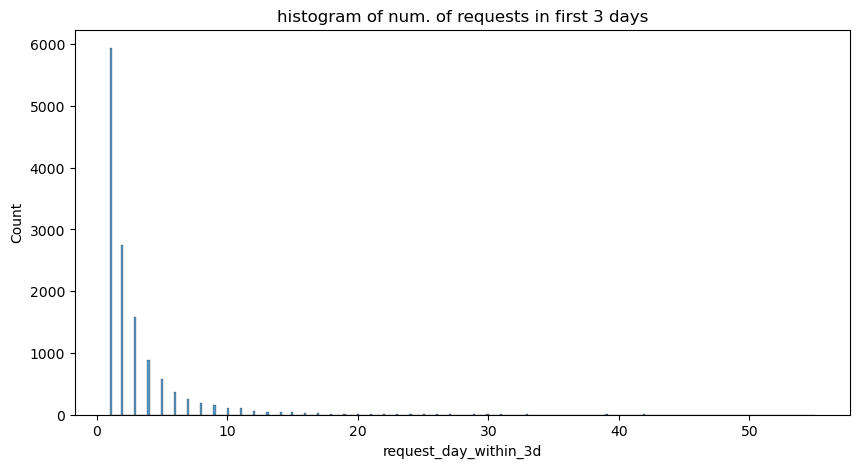

In [54]:
plt.figure(figsize=(10,5))
sns.histplot(final_df, x="request_day_within_3d")
plt.title('histogram of num. of requests in first 3 days')
plt.show()

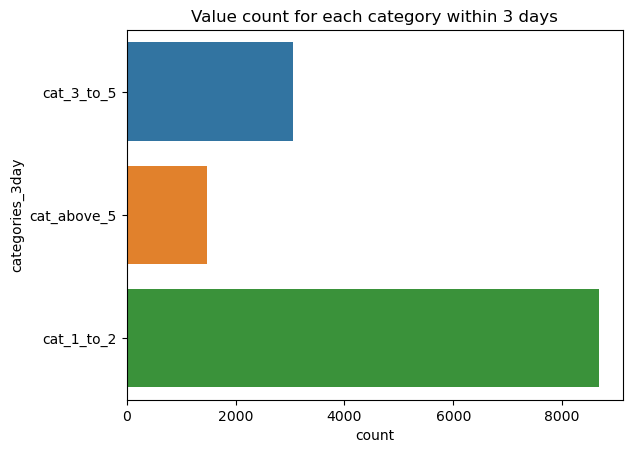

In [55]:
sns.countplot(y=final_df.categories_3day)
plt.title('Value count for each category within 3 days')
plt.show()

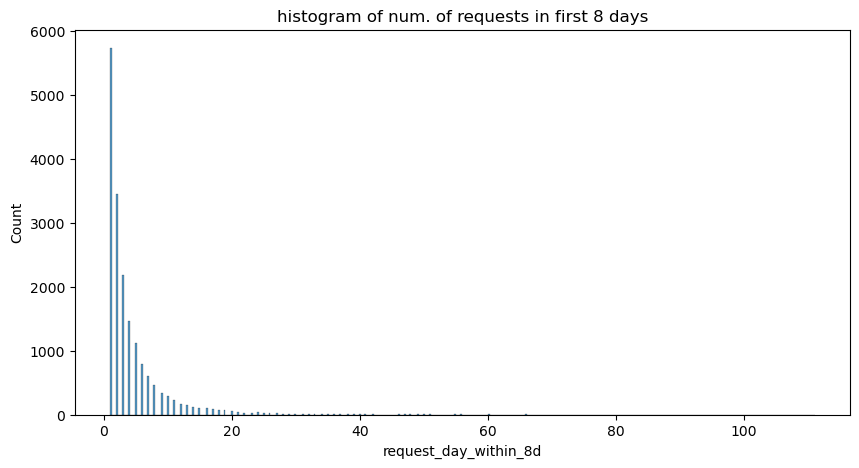

In [56]:
plt.figure(figsize=(10,5))
sns.histplot(final_df, x="request_day_within_8d")
plt.title('histogram of num. of requests in first 8 days')
plt.show()

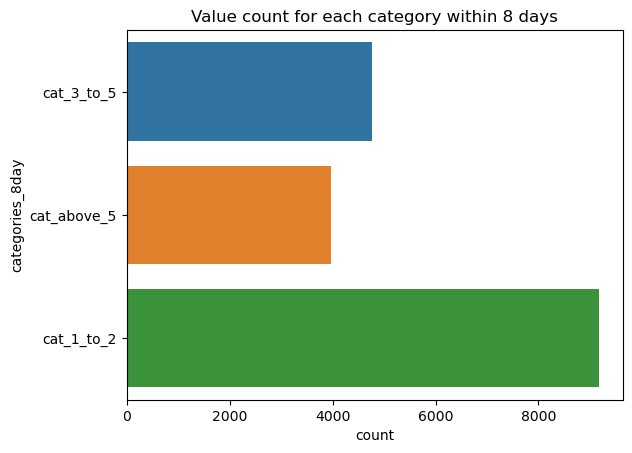

In [57]:
sns.countplot(y=final_df.categories_8day)
plt.title('Value count for each category within 8 days')
plt.show()

In [58]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28888 entries, 0 to 28887
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   28888 non-null  object 
 1   bathroom               28888 non-null  int64  
 2   floor                  28888 non-null  int64  
 3   total_floor            28845 non-null  float64
 4   furnishing             28888 non-null  object 
 5   gym                    28888 non-null  int64  
 6   lease_type             28888 non-null  object 
 7   lift                   28888 non-null  int64  
 8   parking                28888 non-null  object 
 9   property_age           28888 non-null  int64  
 10  property_size          28888 non-null  int64  
 11  swimming_pool          28888 non-null  int64  
 12  rent                   28888 non-null  int64  
 13  deposit                28888 non-null  int64  
 14  building_type          28809 non-null  object 
 15  ph

In [59]:
df_cat = final_df.select_dtypes(include=['object'])

In [60]:
print(df_cat.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28888 entries, 0 to 28887
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   type             28888 non-null  object
 1   furnishing       28888 non-null  object
 2   lease_type       28888 non-null  object
 3   parking          28888 non-null  object
 4   building_type    28809 non-null  object
 5   categories_8day  17925 non-null  object
 6   categories_3day  13210 non-null  object
dtypes: object(7)
memory usage: 1.8+ MB
None


In [61]:
df_num = final_df.select_dtypes(exclude=['object'])

In [62]:
print(df_num.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28888 entries, 0 to 28887
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bathroom               28888 non-null  int64  
 1   floor                  28888 non-null  int64  
 2   total_floor            28845 non-null  float64
 3   gym                    28888 non-null  int64  
 4   lift                   28888 non-null  int64  
 5   property_age           28888 non-null  int64  
 6   property_size          28888 non-null  int64  
 7   swimming_pool          28888 non-null  int64  
 8   rent                   28888 non-null  int64  
 9   deposit                28888 non-null  int64  
 10  photo_count            28888 non-null  int64  
 11  request_day_within_8d  17925 non-null  float64
 12  request_day_within_3d  13210 non-null  float64
dtypes: float64(3), int64(10)
memory usage: 3.1 MB
None


In [63]:
for i in df_cat.columns:
    print('Column Name : ', i)
    print(df_cat[i].value_counts())
    print('\n\n')

Column Name :  type
BHK2        14071
BHK1         6565
BHK3         5725
RK1          2015
BHK4          440
BHK4PLUS       72
Name: type, dtype: int64



Column Name :  furnishing
SEMI_FURNISHED     22463
NOT_FURNISHED       4863
FULLY_FURNISHED     1562
Name: furnishing, dtype: int64



Column Name :  lease_type
FAMILY      14885
ANYONE      12721
BACHELOR     1211
COMPANY        71
Name: lease_type, dtype: int64



Column Name :  parking
BOTH            13809
TWO_WHEELER     12806
NONE             1277
FOUR_WHEELER      996
Name: parking, dtype: int64



Column Name :  building_type
IF    16557
AP    10193
IH     2059
Name: building_type, dtype: int64



Column Name :  categories_8day
cat_1_to_2     9181
cat_3_to_5     4774
cat_above_5    3970
Name: categories_8day, dtype: int64



Column Name :  categories_3day
cat_1_to_2     8681
cat_3_to_5     3049
cat_above_5    1480
Name: categories_3day, dtype: int64





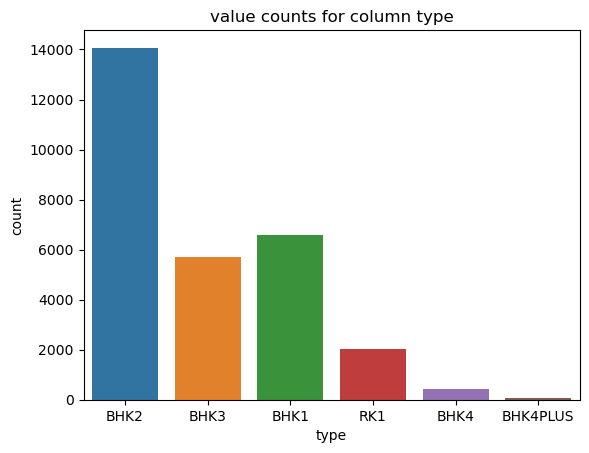

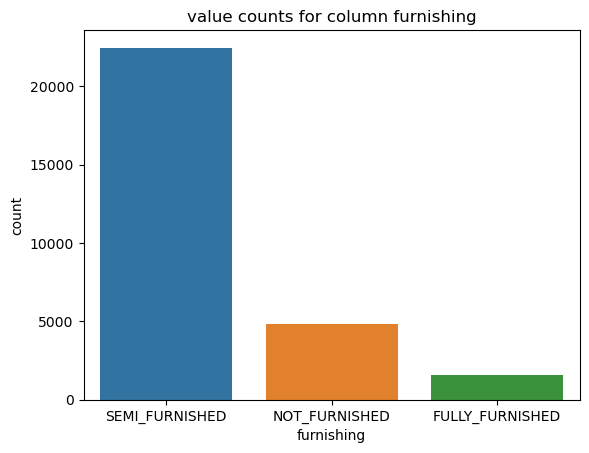

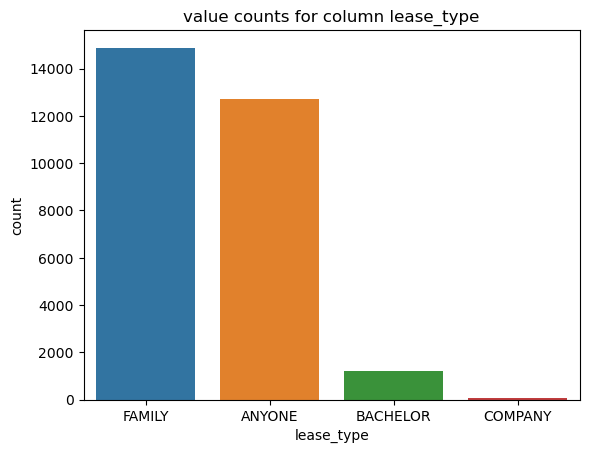

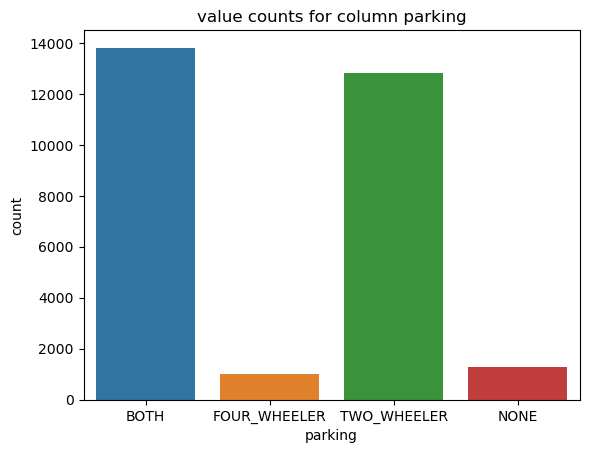

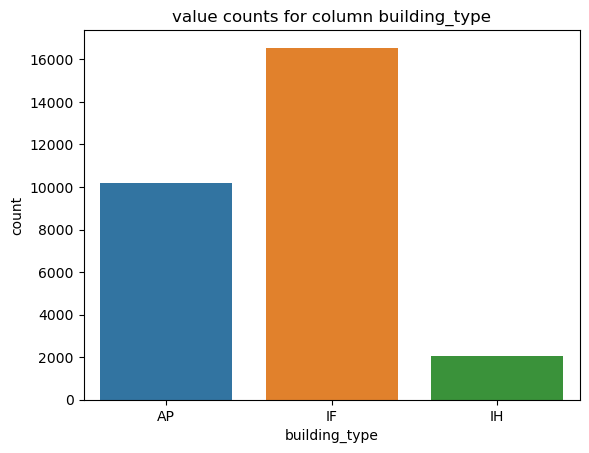

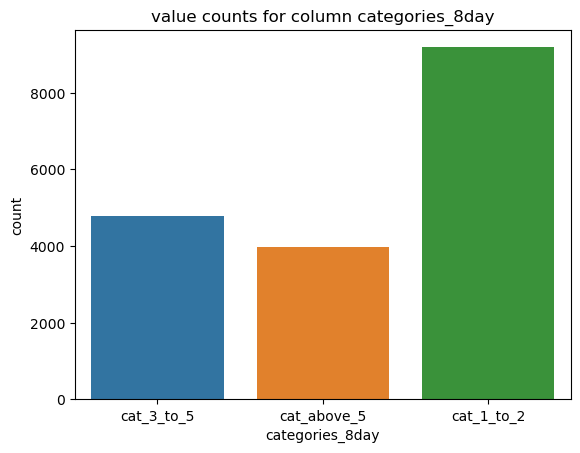

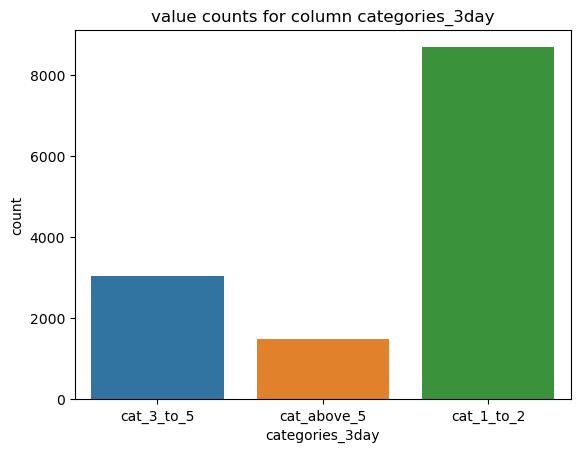

In [64]:
for i in df_cat.columns:
    sns.countplot(x = i,data =final_df)
    plt.title(f'value counts for column {i}')
    plt.show()


In [65]:
df_num.describe()

,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,request_day_within_8d,request_day_within_3d
count,28888.000000,28888.000000,28845.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,2.888800e+04,28888.000000,17925.000000,13210.000000
mean,1.795867,1.786659,3.518807,0.165951,0.279009,4.380539,966.338999,0.142585,14430.768797,1.233257e+05,3.461403,4.253668,2.802801
std,0.778676,2.361768,3.362536,0.372043,0.448520,7.458914,619.390016,0.349655,9055.133718,1.255028e+05,4.230723,5.407670,3.187711
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000e+00,0.000000,1.000000,1.000000
25%,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,600.000000,0.000000,8000.000000,5.000000e+04,0.000000,1.000000,1.000000
50%,2.000000,1.000000,3.000000,0.000000,0.000000,3.000000,900.000000,0.000000,12500.000000,1.000000e+05,2.000000,2.000000,2.000000
75%,2.000000,2.000000,4.000000,0.000000,1.000000,6.000000,1200.000000,0.000000,18000.000000,1.500000e+05,6.000000,5.000000,3.000000
max,22.000000,123.000000,38.000000,1.000000,1.000000,800.000000,40000.000000,1.000000,75000.000000,4.200000e+06,45.000000,111.000000,55.000000


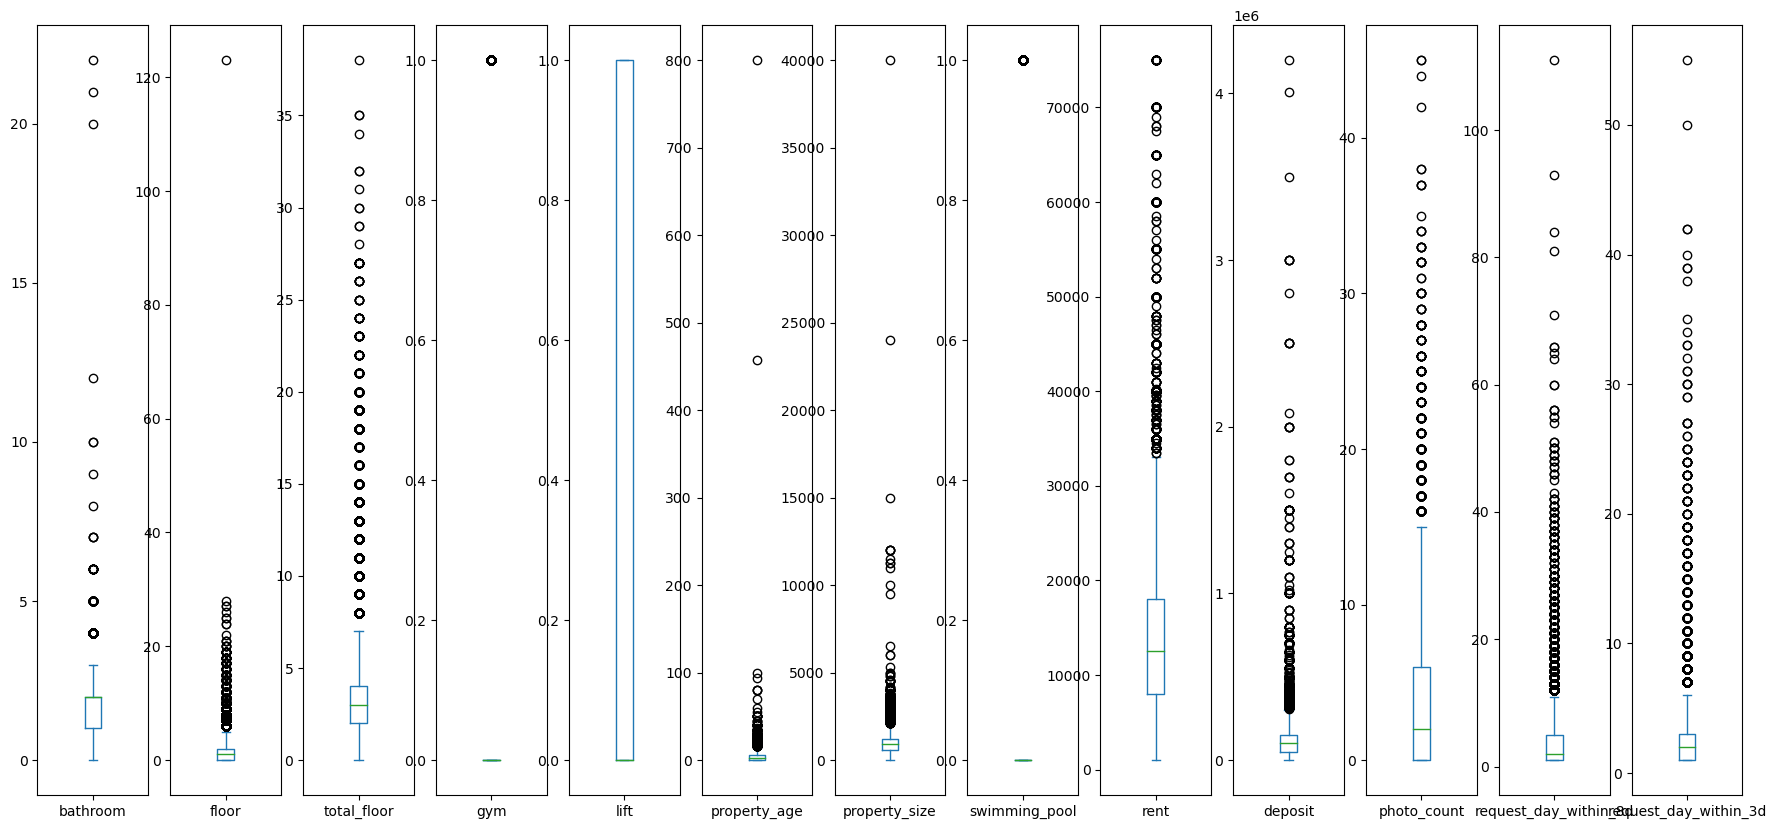

In [66]:
df_num.plot(kind='box', subplots=True, sharex=False, sharey=False,figsize=(22,10))
plt.show()

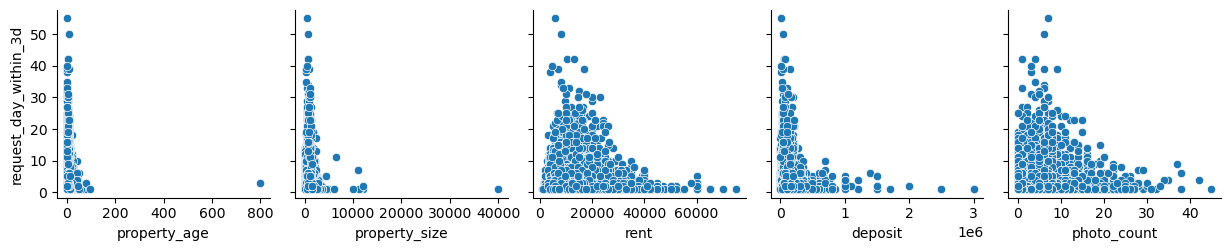

In [67]:
sns.pairplot(data=final_df,
 x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
 y_vars=['request_day_within_3d']
            )

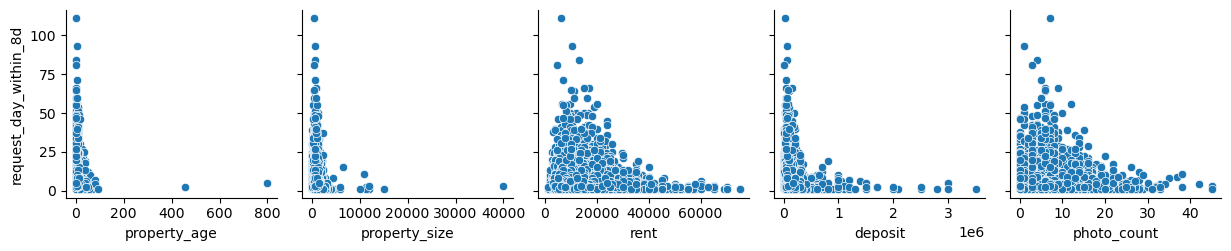

In [68]:
sns.pairplot(data=final_df,
 x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
 y_vars=['request_day_within_8d']
            )

## Checking for Outliers and Nan Values

In [69]:
Q1=df_num.quantile(0.25)
Q3=df_num.quantile(0.75)
IQR=Q3-Q1

In [70]:
print(IQR)

bathroom                      1.0
floor                         2.0
total_floor                   2.0
gym                           0.0
lift                          1.0
property_age                  6.0
property_size               600.0
swimming_pool                 0.0
rent                      10000.0
deposit                  100000.0
photo_count                   6.0
request_day_within_8d         4.0
request_day_within_3d         2.0
dtype: float64


In [71]:
def remove_outliers(df_in,i):
    Q1=df_in[i].quantile(0.25)
    Q3=df_in[i].quantile(0.75)
    IQR=Q3-Q1
    lower_threshold=Q1-1.5*IQR
    upper_threshold=Q3+1.5*IQR
    clean_df = df_in.loc[(df_in[i]<=upper_threshold) & (df_in[i]>=lower_threshold)]
    return clean_df

In [72]:
final_df.shape

(28888, 20)

In [73]:
df_n = final_df.copy()

In [74]:
for i in df_num.columns:
     if i in ['gym', 'lift', 'swimming_pool', 'request_day_within_3d', 'request_day_within_7d']:
            continue
     
     df_n= remove_outliers(df_n , i)

In [75]:
df_n.shape

(13801, 20)

In [76]:
df_n['request_day_within_3d'].value_counts()

1.0     4846
2.0     2281
3.0     1306
4.0      701
5.0      427
6.0      200
7.0      113
8.0       53
9.0       40
10.0      15
11.0      13
Name: request_day_within_3d, dtype: int64

In [77]:
df_n['request_day_within_8d'].value_counts()

1.0     4575
2.0     2826
3.0     1820
4.0     1254
5.0      973
6.0      680
7.0      531
8.0      407
9.0      283
10.0     253
11.0     199
Name: request_day_within_8d, dtype: int64

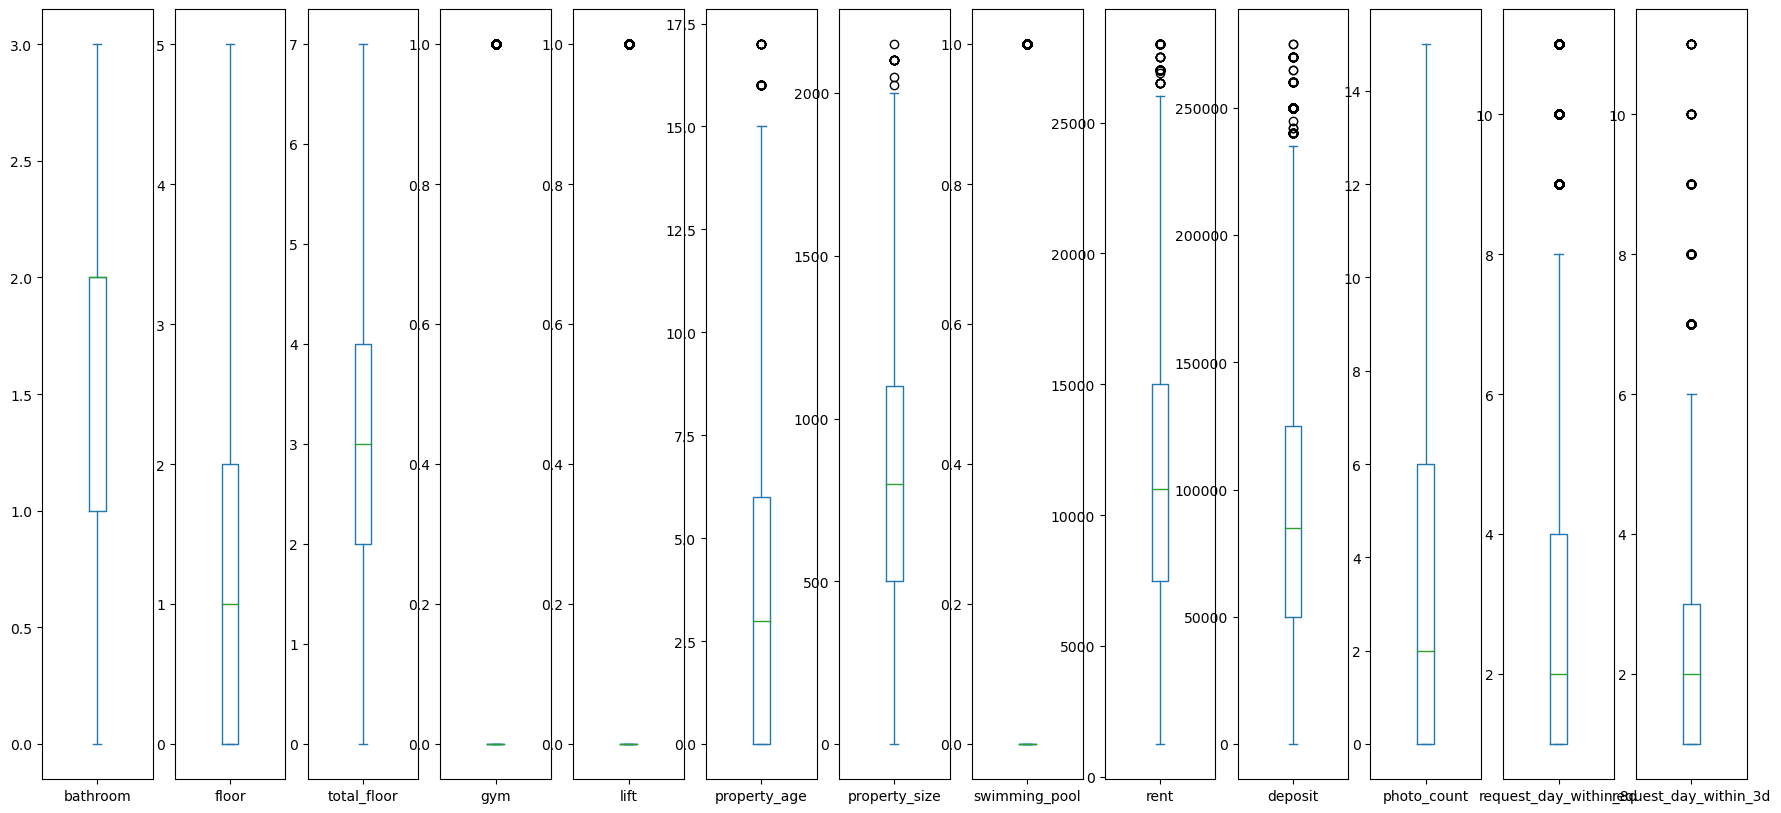

In [78]:
df_n.plot(kind='box', subplots=True, sharex=False, sharey=False,figsize=(22,10))
plt.show()

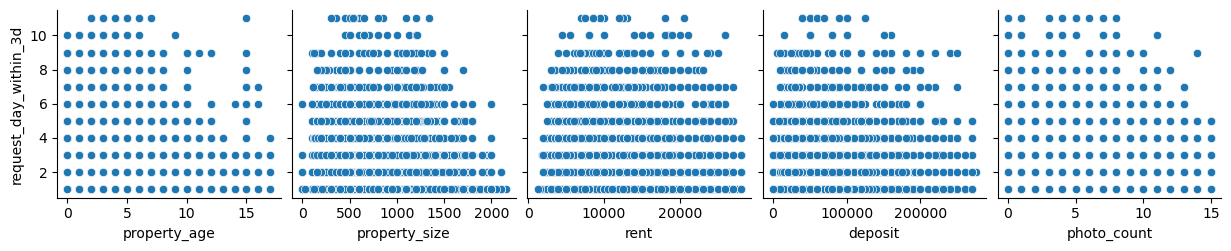

In [79]:
sns.pairplot(data=df_n,
 x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
 y_vars=['request_day_within_3d']
 )
plt.show()


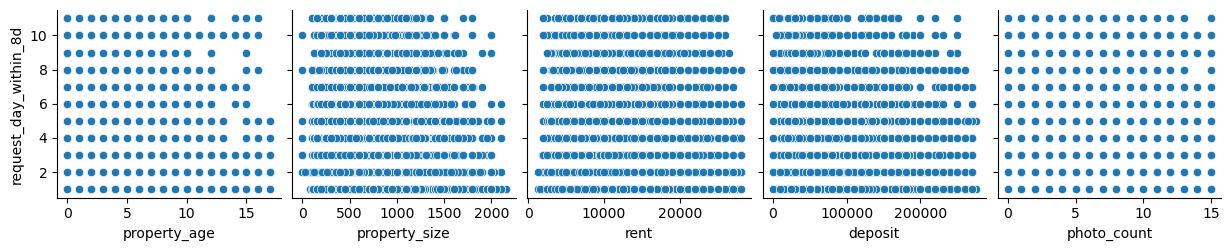

In [80]:
sns.pairplot(data=df_n,
 x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
 y_vars=['request_day_within_8d']
 )
plt.show()


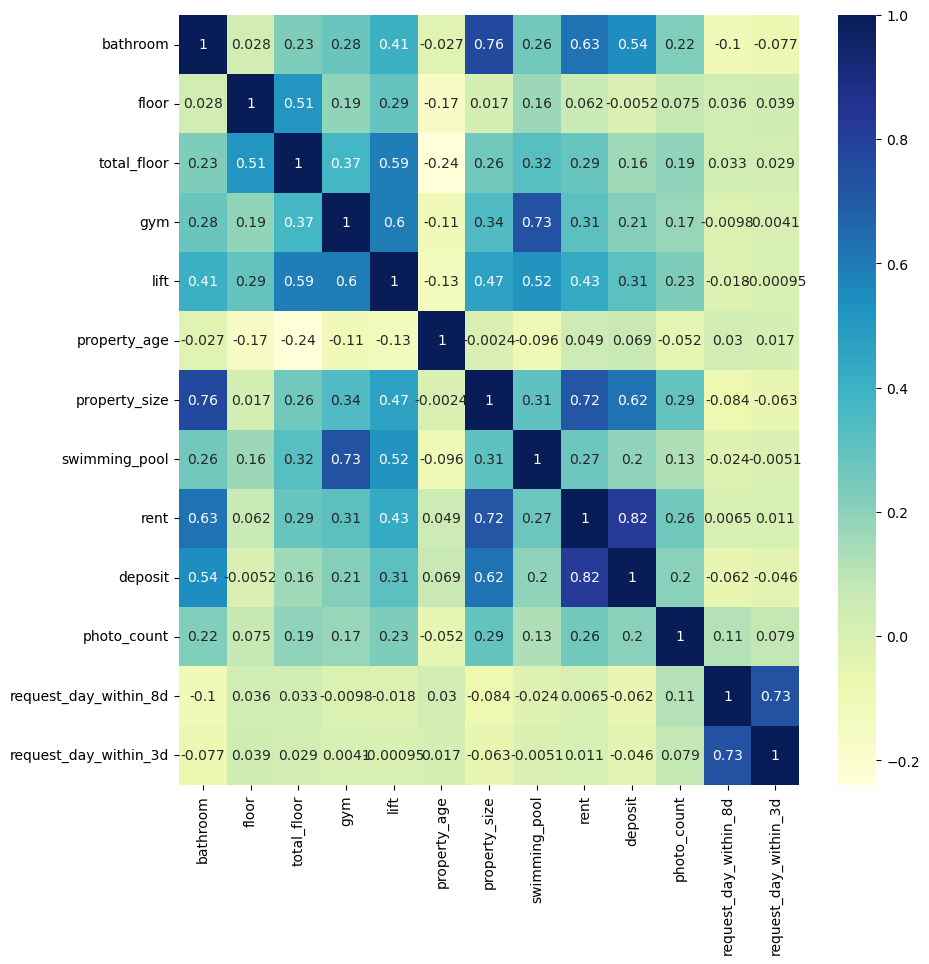

In [81]:
plt.subplots(figsize=(10,10))
dataplot = sns.heatmap(df_n.corr(), cmap="YlGnBu", annot=True)
plt.show()

## Label Encoding 

In [82]:
df_n.columns

Index(['type', 'bathroom', 'floor', 'total_floor', 'furnishing', 'gym',
       'lease_type', 'lift', 'parking', 'property_age', 'property_size',
       'swimming_pool', 'rent', 'deposit', 'building_type', 'photo_count',
       'request_day_within_8d', 'categories_8day', 'request_day_within_3d',
       'categories_3day'],
      dtype='object')

In [83]:
X = df_n.drop(['request_day_within_8d','categories_8day','request_day_within_3d','categories_3day'],axis=1)

In [84]:
X.shape

(13801, 16)

In [85]:
X.columns

Index(['type', 'bathroom', 'floor', 'total_floor', 'furnishing', 'gym',
       'lease_type', 'lift', 'parking', 'property_age', 'property_size',
       'swimming_pool', 'rent', 'deposit', 'building_type', 'photo_count'],
      dtype='object')

In [86]:
y = df_n[['request_day_within_8d','categories_8day','request_day_within_3d','categories_3day']]

In [87]:
y.shape

(13801, 4)

In [88]:
x_cat_all= df_n[X.select_dtypes(include=['O']).columns]
x_num_all = df_n[X.select_dtypes(exclude=['O']).columns]

In [89]:
x_cat_all.shape

(13801, 5)

In [90]:
x_num_all.shape

(13801, 11)

In [91]:
x_cat_all.isna().sum()

type              0
furnishing        0
lease_type        0
parking           0
building_type    15
dtype: int64

In [92]:
x_num_all.isna().sum()

bathroom         0
floor            0
total_floor      0
gym              0
lift             0
property_age     0
property_size    0
swimming_pool    0
rent             0
deposit          0
photo_count      0
dtype: int64

In [93]:
x_cat_all['building_type']=x_cat_all['building_type'].fillna(x_cat_all['building_type'].mode()[0])

In [94]:
x_cat_all.isna().sum()

type             0
furnishing       0
lease_type       0
parking          0
building_type    0
dtype: int64

In [95]:
y.isna().sum()

request_day_within_8d       0
categories_8day             0
request_day_within_3d    3806
categories_3day          3806
dtype: int64

In [96]:
ohe = OneHotEncoder(categories='auto' , handle_unknown='ignore')
feature_train = ohe.fit_transform(x_cat_all).toarray()
feature_labels = ohe.categories_

In [97]:
new_features = []
for i,j in zip(x_cat_all.columns,feature_labels):
     new_features.append(f"{i}_"+j)

In [98]:
feature_labels = np.array(new_features, dtype=object).ravel()
f=[]
for i in range(feature_labels.shape[0]):
     f.extend(feature_labels[i])
df_features = pd.DataFrame(feature_train, columns=f)

In [99]:
print(df_features.shape)

(13801, 20)


In [100]:
df_features.head(3)

,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY,parking_BOTH,parking_FOUR_WHEELER,parking_NONE,parking_TWO_WHEELER,building_type_AP,building_type_IF,building_type_IH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [101]:
df_features.isna().sum()

type_BHK1                     0
type_BHK2                     0
type_BHK3                     0
type_BHK4                     0
type_BHK4PLUS                 0
type_RK1                      0
furnishing_FULLY_FURNISHED    0
furnishing_NOT_FURNISHED      0
furnishing_SEMI_FURNISHED     0
lease_type_ANYONE             0
lease_type_BACHELOR           0
lease_type_COMPANY            0
lease_type_FAMILY             0
parking_BOTH                  0
parking_FOUR_WHEELER          0
parking_NONE                  0
parking_TWO_WHEELER           0
building_type_AP              0
building_type_IF              0
building_type_IH              0
dtype: int64

In [106]:
concat_3day_data=pd.concat([df_features.reset_index(drop=True),x_num_all.reset_index(drop=True),y[['request_day_within_3d','categories_3day']].reset_index(drop=True)],axis=1)

In [107]:
concat_3day_data.shape

(13801, 33)

In [108]:
concat_8day_data=pd.concat([df_features.reset_index(drop=True),x_num_all.reset_index(drop=True),y[['request_day_within_8d','categories_8day']].reset_index(drop=True)],axis=1)

In [109]:
concat_8day_data.isna().sum()

type_BHK1                     0
type_BHK2                     0
type_BHK3                     0
type_BHK4                     0
type_BHK4PLUS                 0
type_RK1                      0
furnishing_FULLY_FURNISHED    0
furnishing_NOT_FURNISHED      0
furnishing_SEMI_FURNISHED     0
lease_type_ANYONE             0
lease_type_BACHELOR           0
lease_type_COMPANY            0
lease_type_FAMILY             0
parking_BOTH                  0
parking_FOUR_WHEELER          0
parking_NONE                  0
parking_TWO_WHEELER           0
building_type_AP              0
building_type_IF              0
building_type_IH              0
bathroom                      0
floor                         0
total_floor                   0
gym                           0
lift                          0
property_age                  0
property_size                 0
swimming_pool                 0
rent                          0
deposit                       0
photo_count                   0
request_

In [110]:
concat_3day_data.isna().sum()

type_BHK1                        0
type_BHK2                        0
type_BHK3                        0
type_BHK4                        0
type_BHK4PLUS                    0
type_RK1                         0
furnishing_FULLY_FURNISHED       0
furnishing_NOT_FURNISHED         0
furnishing_SEMI_FURNISHED        0
lease_type_ANYONE                0
lease_type_BACHELOR              0
lease_type_COMPANY               0
lease_type_FAMILY                0
parking_BOTH                     0
parking_FOUR_WHEELER             0
parking_NONE                     0
parking_TWO_WHEELER              0
building_type_AP                 0
building_type_IF                 0
building_type_IH                 0
bathroom                         0
floor                            0
total_floor                      0
gym                              0
lift                             0
property_age                     0
property_size                    0
swimming_pool                    0
rent                

In [111]:
concat_3day_data.dropna(inplace=True)

## Predicting Interaction within 3 days 

In [112]:
concat_3day_data.columns

Index(['type_BHK1', 'type_BHK2', 'type_BHK3', 'type_BHK4', 'type_BHK4PLUS',
       'type_RK1', 'furnishing_FULLY_FURNISHED', 'furnishing_NOT_FURNISHED',
       'furnishing_SEMI_FURNISHED', 'lease_type_ANYONE', 'lease_type_BACHELOR',
       'lease_type_COMPANY', 'lease_type_FAMILY', 'parking_BOTH',
       'parking_FOUR_WHEELER', 'parking_NONE', 'parking_TWO_WHEELER',
       'building_type_AP', 'building_type_IF', 'building_type_IH', 'bathroom',
       'floor', 'total_floor', 'gym', 'lift', 'property_age', 'property_size',
       'swimming_pool', 'rent', 'deposit', 'photo_count',
       'request_day_within_3d', 'categories_3day'],
      dtype='object')

In [113]:
X3=concat_3day_data.drop(['request_day_within_3d', 'categories_3day'],axis=1)
y3=concat_3day_data[['request_day_within_3d', 'categories_3day']]

In [114]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X3, y3['request_day_within_3d'], test_size = 0.2, random_state = seed)

In [115]:
sc = MinMaxScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

In [116]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X3, y3['request_day_within_3d'], test_size = 0.2, random_state = seed)
# Try to make a model with these algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(random_state=seed)))
models.append(('xgb', xgb.XGBRegressor(random_state=seed)))
models.append(('lgb', lgb.LGBMRegressor(random_state=seed)))
results = []
names = []
for name, model in models:
 # model 
 regressor = model
 # fit model with train data
 regressor.fit(X_train, y_train)
 # predict after training 
 y_pred=regressor.predict(X_test)
 # calc. root mean squre error 
 rms = np.sqrt(mean_squared_error(y_test, y_pred))
 
 msg = "%s: RMS => (%f)" % (name, rms)
 print(msg)

LR: RMS => (1.525000)
KNN: RMS => (1.697487)
RF: RMS => (1.585431)
xgb: RMS => (1.641542)
lgb: RMS => (1.551178)


In [124]:
rf=RandomForestRegressor(random_state=seed)

In [125]:
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [127]:
r = permutation_importance(rf, X_test, y_test,n_repeats=30,random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X3.columns[i]:<8}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

rent    0.053 +/- 0.011
photo_count0.048 +/- 0.014
type_BHK30.043 +/- 0.009
deposit 0.037 +/- 0.012
property_size0.030 +/- 0.009
total_floor0.017 +/- 0.007
property_age0.014 +/- 0.006
building_type_AP0.006 +/- 0.002
furnishing_NOT_FURNISHED0.004 +/- 0.002
type_BHK40.000 +/- 0.000


In [132]:
xbg_reg = xgb.XGBRegressor().fit(X_train, y_train)

In [133]:
xbg_reg.get_booster().get_score(importance_type='gain')

{'type_BHK1': 2.7043447494506836,
 'type_BHK2': 4.311096668243408,
 'type_BHK3': 15.380013465881348,
 'type_BHK4': 2.1991469860076904,
 'type_RK1': 2.2253737449645996,
 'furnishing_FULLY_FURNISHED': 2.463920831680298,
 'furnishing_NOT_FURNISHED': 3.522012233734131,
 'furnishing_SEMI_FURNISHED': 4.1814422607421875,
 'lease_type_ANYONE': 2.8492486476898193,
 'lease_type_BACHELOR': 3.1793150901794434,
 'lease_type_COMPANY': 1.8712353706359863,
 'lease_type_FAMILY': 4.903696537017822,
 'parking_BOTH': 4.189262390136719,
 'parking_FOUR_WHEELER': 4.260855674743652,
 'parking_NONE': 3.3263742923736572,
 'parking_TWO_WHEELER': 4.716093063354492,
 'building_type_AP': 3.687614917755127,
 'building_type_IF': 4.276914119720459,
 'building_type_IH': 4.1400980949401855,
 'bathroom': 3.478546380996704,
 'floor': 3.4196197986602783,
 'total_floor': 3.882767677307129,
 'gym': 3.7546584606170654,
 'lift': 5.5921854972839355,
 'property_age': 3.9763922691345215,
 'property_size': 4.136532783508301,
 'swi

In [134]:
f_importance = xbg_reg.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')

<Axes: >

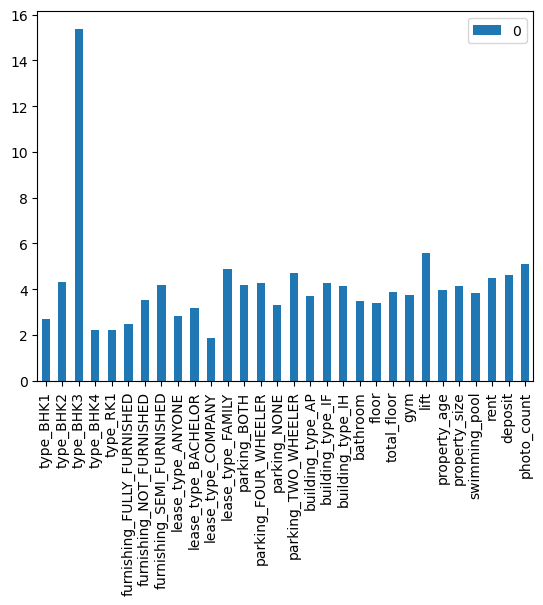

In [135]:
importance_df.plot.bar()

## Predicting Interaction within 8 days

In [117]:
concat_8day_data.columns

Index(['type_BHK1', 'type_BHK2', 'type_BHK3', 'type_BHK4', 'type_BHK4PLUS',
       'type_RK1', 'furnishing_FULLY_FURNISHED', 'furnishing_NOT_FURNISHED',
       'furnishing_SEMI_FURNISHED', 'lease_type_ANYONE', 'lease_type_BACHELOR',
       'lease_type_COMPANY', 'lease_type_FAMILY', 'parking_BOTH',
       'parking_FOUR_WHEELER', 'parking_NONE', 'parking_TWO_WHEELER',
       'building_type_AP', 'building_type_IF', 'building_type_IH', 'bathroom',
       'floor', 'total_floor', 'gym', 'lift', 'property_age', 'property_size',
       'swimming_pool', 'rent', 'deposit', 'photo_count',
       'request_day_within_8d', 'categories_8day'],
      dtype='object')

In [118]:
X8=concat_8day_data.drop(['request_day_within_8d', 'categories_8day'],axis=1)
y8=concat_8day_data[['request_day_within_8d', 'categories_8day']]

In [119]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(X8, y8['request_day_within_8d'], test_size = 0.2, random_state = 42)

In [120]:
X_train0=sc.fit_transform(X_train0)
X_test0=sc.fit_transform(X_test0)

In [121]:
seed = 42
# Try to make a model with these algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(random_state=seed)))
models.append(('xgb', xgb.XGBRegressor(random_state=seed)))
models.append(('lgb', lgb.LGBMRegressor(random_state=seed)))
results = []
names = []
for name, model in models:
 # model 
 regressor = model
 # fit model with train data
 regressor.fit(X_train, y_train)
 # predict after training 
 y_pred=regressor.predict(X_test)
 # calc. root mean squre error 
 rms = np.sqrt(mean_squared_error(y_test, y_pred))
 
 msg = "%s: RMS => (%f)" % (name, rms)
 print(msg)

LR: RMS => (1.525000)
KNN: RMS => (1.697487)
RF: RMS => (1.585431)
xgb: RMS => (1.641542)
lgb: RMS => (1.551178)


In [128]:
rf0=RandomForestRegressor(random_state=seed)

In [129]:
rf0.fit(X_train0,y_train0)

RandomForestRegressor(random_state=42)

In [131]:
r = permutation_importance(rf, X_test0, y_test0,n_repeats=30,random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X8.columns[i]:<8}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

type_BHK30.032 +/- 0.005
photo_count0.023 +/- 0.007
type_BHK20.006 +/- 0.002
parking_NONE0.002 +/- 0.001
parking_TWO_WHEELER0.002 +/- 0.001
property_age0.001 +/- 0.001
lift    0.001 +/- 0.000
parking_FOUR_WHEELER0.001 +/- 0.000
lease_type_BACHELOR0.001 +/- 0.000


In [136]:
xbg_reg0 = xgb.XGBRegressor().fit(X_train0, y_train0)

In [137]:
xbg_reg0.get_booster().get_score(importance_type='gain')

{'f0': 13.83288860321045,
 'f1': 16.512697219848633,
 'f2': 50.20183563232422,
 'f3': 8.025733947753906,
 'f5': 12.44610595703125,
 'f6': 5.58058500289917,
 'f7': 9.270526885986328,
 'f8': 17.790515899658203,
 'f9': 6.882480144500732,
 'f10': 10.183162689208984,
 'f11': 6.492349147796631,
 'f12': 26.373043060302734,
 'f13': 10.523470878601074,
 'f14': 10.256516456604004,
 'f15': 9.563570976257324,
 'f16': 13.446282386779785,
 'f17': 10.783839225769043,
 'f18': 12.678747177124023,
 'f19': 10.456521987915039,
 'f20': 21.978334426879883,
 'f21': 10.155401229858398,
 'f22': 9.676732063293457,
 'f23': 7.669254779815674,
 'f24': 16.10846519470215,
 'f25': 12.053640365600586,
 'f26': 12.427391052246094,
 'f27': 9.657195091247559,
 'f28': 14.419334411621094,
 'f29': 13.570853233337402,
 'f30': 18.658945083618164}

In [138]:
f_importance0 = xbg_reg0.get_booster().get_score(importance_type='gain')

importance_df0 = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')

<Axes: >

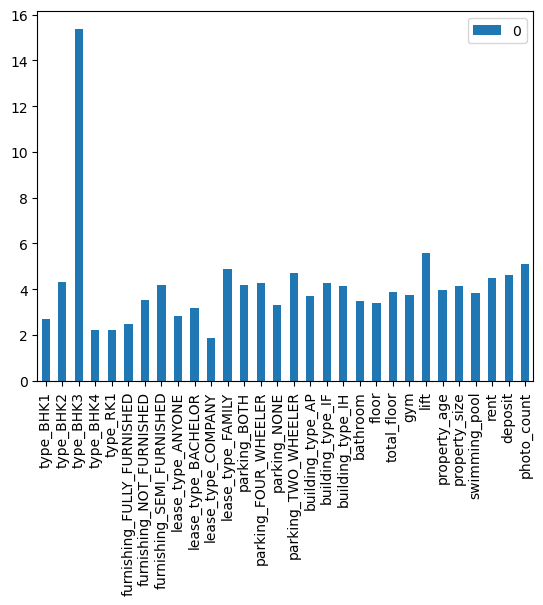

In [139]:
importance_df0.plot.bar()